In [91]:
%%html
<style>
.text_cell {
    font-family: "Vazir", "Segoe UI";
}
.rendered_html p {
    text-align: right;
}
.text_cell {
    direction: rtl;
}
div.input {
    flex-direction: row-reverse;
}
</style>

# هوش مصنوعی - پروژه چهارم
## حسین سلطانلو - ۸۱۰۱۹۵۴۰۷

### فاز صفر: 
در اولین قدم نیاز داریم تا به پیش‌پردازش داده‌ها بپردازیم. برای این کار نیاز داریم تا تاریخ را به یک داده‌ی قابل پردازش تبدیل کنیم. از این رو اطلاعاتی که به نظر می‌توانند مفید باشند را از روی تاریخ خام به‌دست می‌آوریم و در واقع یک‌سری feature جدید از آن استخراج می‌کنیم. این اطلاعات شامل روز هفته، روز ماه، روز سال و ماه است. مثلاً اگر به همان تاریخ خام بسنده کنیم، از آن‌جا که تاریخ‌ها بسیار پخش هستند، کمک خاصی به ما نخواهند کرد و مدل ما بیش‌تر overfit خواهد شد.

In [53]:
import pandas as pd
import numpy as np

data = pd.read_csv('data.csv')
data.drop(data.columns[[0]], axis=1, inplace=True)

data['Date']= pd.to_datetime(data['Date'])
data['Month'] = data['Date'].dt.month
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['DayOfYear'] = data['Date'].dt.dayofyear
data['DayOfMonth'] = data['Date'].dt.day
data.head()

unencoded_data = data.copy(deep=True)

در این قسمت از یک scaler بهره می‌گیریم تا در برخی مدل‌هایی که در ادامه به آن‌ها اشاره می‌شود از آن استفاده کنیم و داده‌ها را scale کنیم. علت انجام این کار این است که ارزش عددی را از داده‌ها سلب کنیم و در مدلی مانند K Nearest Neighbors که بر مبنای فاصله‌های عددی کار می‌کند، تمامی featureها در یک مقیاس باشند تا از وزن‌دهی ناخواسته به آن‌ها براثر عدم تطابق مقیاس‌ها جلوگیری شود و هر feature مشارکتی برابر با بقیه در محاسبه‌ی فواصل داشته باشد.

In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

این مرحله مختص به متناسب‌سازی داده‌های categorical است. بسیاری از مدل‌های یادگیری ماشین فقط با داده‌های عددی سر و کار دارند و باید به نحوی این‌گونه داده‌های categorical را به داده‌های عددی تبدیل کنیم. برای این کار روش‌های متنوعی وجود دارد که در این‌جا از دو روش Label Encoding و One Hot Encoding استفاده می‌کنیم. در روش Lable Encoding به هر نوع از یک دسته، یک عدد اختصاص می‌یابد. ایراد این کار این است که با این کار به آن‌ها ارزش عددی و ترتیب می‌دهیم که مطلوب نیست و ممکن است باعث انحراف یادگیری مدل شود. برای حل این مشکل از روش One Hot Encoding استفاده می‌کنیم. One Hot Encoding به هر دسته یک ستون اختصاص می‌دهد و هر سطری که جزو آن دسته باشد را با 1 نمایش می‌دهد. ایراد استفاده از این روش این است که منجر به افزایش بسیار زیاد تعداد featureها و هم‌چنین بزرگ‌شدن جدول داده‌ها می‌شود.\
در مدل‌های درخت تصمیم فقط از داده‌هایی که Label Encode شده‌اند استفاده می‌کنیم؛ چرا که One Hot Encoding باعث عدم توازن در درخت خواهد شد.

In [55]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
data['Country Type'] = labelencoder.fit_transform(data['Country'])
unencoded_data['Country Type'] = labelencoder.fit_transform(unencoded_data['Country'])
data['Is Back'] = labelencoder.fit_transform(data['Is Back'])
unencoded_data['Is Back'] = labelencoder.fit_transform(data['Is Back'])
onehotencoder = OneHotEncoder(handle_unknown='ignore')
encoded_data = pd.DataFrame(onehotencoder.fit_transform(data[['Country Type']]).toarray())
data = data.join(encoded_data)

data.drop(['Country', 'Date'], axis=1, inplace=True)
unencoded_data.drop(['Country', 'Date'], axis=1, inplace=True)


در این بخش Information Gain مربوط به featureها نسبت به Is Back محاسبه می‌شود. همان‌گونه که در نمودار دیده می‌شود، روز سال می‌تواند بیش‌تر از بقیه‌ی موارد در درخت تصمیم‌گیری کمک‌کننده باشد که می‌تواند منطقی باشد؛ چرا که در بازه‌های مختلف سال، خریدها به‌شکل مناسبتی و فصلی انجام می‌گیرد و تمایز زیادی بین این‌که فرد باز هم خرید بکند یا خیر ایجاد می‌کند. همین امر در مورد این‌که در چه ماهی از سال خرید صورت گرفته می‌تواند صحیح باشد.

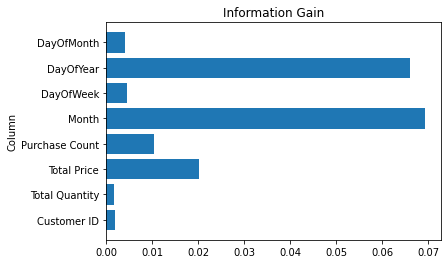

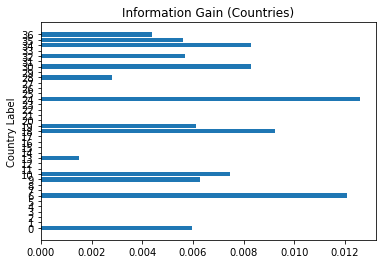

In [56]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

ig = mutual_info_classif(data.loc[:, data.columns != 'Is Back'], data['Is Back'])

cols = tuple(data.loc[:, data.columns != 'Is Back'].columns.values[:8])
y_pos = np.arange(len(cols))
plt.barh(y_pos, ig[:8], align='center')
plt.yticks(y_pos, cols)
plt.ylabel('Column')
plt.title('Information Gain')
plt.show()

cols = tuple(data.loc[:, data.columns != 'Is Back'].columns.values[9:])
y_pos = np.arange(len(cols))
plt.barh(y_pos, ig[9:], align='center')
plt.yticks(y_pos, cols)
plt.ylabel('Country Label')
plt.title('Information Gain (Countries)')
plt.show()

### فاز اول:
در این قسمت داده‌ها را به دو بخش train و test با نسبت ۸۰/۲۰ تقسیم می‌کنیم.

In [57]:
from sklearn.model_selection import train_test_split

x = data.loc[:, data.columns != 'Is Back']
x = x.drop(x.columns[[0, 8]], axis=1)
unencoded_data_x = unencoded_data.loc[:, unencoded_data.columns != 'Is Back']
unencoded_data_x = unencoded_data_x.drop(unencoded_data_x.columns[[0]], axis=1)
unencoded_data_x['Total Quantity'] = unencoded_data_x['Total Quantity'] // 10

y = data['Is Back']
unencoded_data_y = unencoded_data['Is Back']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 5)
unenc_x_train, unenc_x_test, unenc_y_train, unenc_y_test = train_test_split(unencoded_data_x, unencoded_data_y, test_size = 0.2, random_state = 5)

In [58]:
def report(data_type, acc, pre, rec):
    print(f'---{data_type.upper()} DATA REPORT:---\nACCURACY: %{int(acc * 100)}\nPRECISION: %{int(pre * 100)}\nRECALL: %{int(rec * 100)}\n')

در ادامه به محاسبه‌ی دقت مدل KNN برای تعداد همسایه‌های بین ۱ تا ۳۰ می‌پردازیم تا ببینیم بهترین مقدار برای آن کدام است. برای این مدل داده‌های scaleشده و هم‌چنین encodeشده استفاده شده است. scaleشدن از آن‌جا مهم است که در این مدل به فاصله‌ها وابسته‌ایم و هم‌چنین برای محاسبه‌ی فواصل نیاز به داده‌های عددی داریم. پس نیاز است که داده‌های طبقه‌ای نیز به داده‌های عددی تبدیل شوند.

In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

k_range = range(1,31)
knn_train_acc = {}
knn_train_acc_list = []
knn_train_pre = {}
knn_train_pre_list = []
knn_train_rec = {}
knn_train_rec_list = []
knn_test_acc = {}
knn_test_acc_list = []
knn_test_pre = {}
knn_test_pre_list = []
knn_test_rec = {}
knn_test_rec_list = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(scaler.fit_transform(x_train), y_train)
    knn_y_train_pred = knn.predict(scaler.fit_transform(x_train))
    knn_y_test_pred = knn.predict(scaler.fit_transform(x_test))

    knn_train_acc[k] = metrics.accuracy_score(y_train, knn_y_train_pred)
    knn_test_acc[k] = metrics.accuracy_score(y_test, knn_y_test_pred)
    knn_train_acc_list.append(knn_train_acc[k])
    knn_test_acc_list.append(knn_test_acc[k])

    knn_train_pre[k] = metrics.precision_score(y_train, knn_y_train_pred, average='weighted')
    knn_test_pre[k] = metrics.precision_score(y_test, knn_y_test_pred, average='weighted')
    knn_train_pre_list.append(knn_train_pre[k])
    knn_test_pre_list.append(knn_test_pre[k])

    knn_train_rec[k] = metrics.recall_score(y_train, knn_y_train_pred, average='weighted')
    knn_test_rec[k] = metrics.recall_score(y_test, knn_y_test_pred, average='weighted')
    knn_train_rec_list.append(knn_train_rec[k])
    knn_test_rec_list.append(knn_test_rec[k])

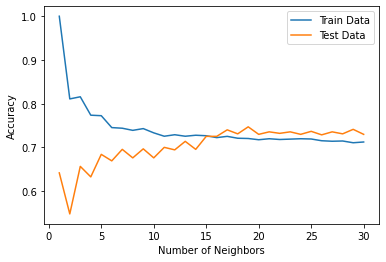

In [60]:
import matplotlib.pyplot as plt

plt.plot(k_range, knn_train_acc_list, label='Train Data')
plt.plot(k_range, knn_test_acc_list, label='Test Data')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

مشاهده می‌شود که برای مقدار همسایه‌های بین ۱ تا ۵، دقت مدل برای داده‌های train بسیار بالاتر از داده‌های test است و در واقع overfit رخ داده است. دلیل آن نیز این است که اگر همسایه‌های کمی در نظر گرفته شود، در واقع داریم فقط بر اساس چیزهایی که در داده‌ی یادگیری دیده‌ایم قضاوت می‌کنیم. پس مقداری که برمی‌گزینیم طبق نمودار در بازه‌ی بیش از ۱۵ است که در این‌جا مقدار ۱۹ را انتخاب کرده‌ایم. البته باید دقت داشت که اگر این مقدار بسیار بالا برود نیز دچار underfit خواهیم شد، چرا که محدوده‌ی همسایه‌ی بسیار بزرگی در نظر گرفته می‌شود.\
درصد معیارهای دقت نیز در ادامه آمده است.

In [61]:
best_k = 19
report("knn train",knn_train_acc[best_k], knn_train_pre[best_k], knn_train_rec[best_k])
report("knn test",knn_test_acc[best_k], knn_test_pre[best_k], knn_test_rec[best_k])

---KNN TRAIN DATA REPORT:---
ACCURACY: %72
PRECISION: %70
RECALL: %72

---KNN TEST DATA REPORT:---
ACCURACY: %74
PRECISION: %72
RECALL: %74



در این قسمت دقت مدل درخت تصمیم برای حداکثر عمق ۱ تا ۳۰ محاسبه شده است. گفتنی است که برای این مدل به جز استخراج داده‌های جدید از تاریخ، عمل دیگری برای پیش‌پردازش صورت نگرفته است. 

In [62]:
from sklearn.tree import DecisionTreeClassifier

d_range = range(1,31)
dt_train_acc = {}
dt_train_acc_list = []
dt_train_pre = {}
dt_train_pre_list = []
dt_train_rec = {}
dt_train_rec_list = []
dt_test_acc = {}
dt_test_acc_list = []
dt_test_pre = {}
dt_test_pre_list = []
dt_test_rec = {}
dt_test_rec_list = []
for d in d_range:
    dtc = DecisionTreeClassifier(max_depth=d)
    dtc.fit(unenc_x_train, unenc_y_train)
    dt_y_train_pred = dtc.predict(unenc_x_train)
    dt_y_test_pred = dtc.predict(unenc_x_test)

    dt_train_acc[d] = metrics.accuracy_score(unenc_y_train, dt_y_train_pred)
    dt_test_acc[d] = metrics.accuracy_score(unenc_y_test, dt_y_test_pred)
    dt_train_acc_list.append(dt_train_acc[d])
    dt_test_acc_list.append(dt_test_acc[d])

    dt_train_pre[d] = metrics.precision_score(unenc_y_train, dt_y_train_pred, average='weighted', zero_division=1)
    dt_test_pre[d] = metrics.precision_score(unenc_y_test, dt_y_test_pred, average='weighted', zero_division=1)
    dt_train_pre_list.append(dt_train_pre[d])
    dt_test_pre_list.append(dt_test_pre[d])

    dt_train_rec[d] = metrics.recall_score(unenc_y_train, dt_y_train_pred, average='weighted', zero_division=1)
    dt_test_rec[d] = metrics.recall_score(unenc_y_test, dt_y_test_pred, average='weighted', zero_division=1)
    dt_train_rec_list.append(dt_train_rec[d])
    dt_test_rec_list.append(dt_test_rec[d])

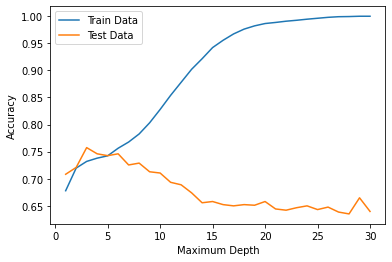

In [63]:
plt.plot(d_range, dt_train_acc_list, label='Train Data')
plt.plot(d_range, dt_test_acc_list, label='Test Data')
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

مشاهده می‌شود که با افزایش حداکثر ارتفاع درخت، تفاوت بین دقت داده‌ی یادگیری و آزمون زیادتر می‌شود. دلیل این امر نیز آن است که ارتفاع درخت هرچه بالاتر برود، مدل از generalization خارج می‌شود و در واقع تصمیم‌گیری‌هایی که روی گره‌های درخت انجام شده، وابستگی بیش‌تری به داده پیدا کرده است و در نتیجه برای داده‌ی آزمون، دقت بسیار پایین‌تری خواهیم داشت.\
درصد معیارهای دقت نیز در ادامه برای حداکثر ارتفاع ۵ محاسبه شده است.

In [64]:
best_d = 5
report("decision tree train",dt_train_acc[best_d], dt_train_pre[best_d], dt_train_rec[best_d])
report("decision tree test",dt_test_acc[best_d], dt_test_pre[best_d], dt_test_rec[best_d])

---DECISION TREE TRAIN DATA REPORT:---
ACCURACY: %74
PRECISION: %73
RECALL: %74

---DECISION TREE TEST DATA REPORT:---
ACCURACY: %74
PRECISION: %72
RECALL: %74



در این بخش معیارهای دقت را برای مدل Logistic Regression مشاهده می‌کنیم. داده‌هایی که به این مدل برای یادگیری داده می‌شوند همانند داده‌هایی هستند که به مدل KNN دادیم.

In [65]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(x_train, y_train)
lr_y_train_pred = lr.predict(x_train)
lr_y_test_pred = lr.predict(x_test)
lr_train_acc = metrics.accuracy_score(y_train, lr_y_train_pred)
lr_train_rec = metrics.recall_score(y_train, lr_y_train_pred, average='weighted')
lr_train_pre = metrics.precision_score(y_train, lr_y_train_pred, average='weighted')
lr_test_acc = metrics.accuracy_score(y_test, lr_y_test_pred)
lr_test_rec = metrics.recall_score(y_test, lr_y_test_pred, average='weighted')
lr_test_pre = metrics.precision_score(y_test, lr_y_test_pred, average='weighted')

report("logistic regression train",lr_train_acc, lr_train_pre, lr_train_rec)
report("logistic regression test",lr_test_acc, lr_test_pre, lr_test_rec)

---LOGISTIC REGRESSION TRAIN DATA REPORT:---
ACCURACY: %68
PRECISION: %68
RECALL: %68

---LOGISTIC REGRESSION TEST DATA REPORT:---
ACCURACY: %71
PRECISION: %67
RECALL: %71



### فاز دوم:
با بررسی معیارهای دقت در مدل Bagging مبتنی بر Decision Tree مشاهده می‌شود که نسبت به حالت عادی با افزایش دقت مواجهیم.

In [66]:
from sklearn.ensemble import BaggingClassifier

bc_dt = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=best_d), max_features=0.5, max_samples=0.5)
bc_dt.fit(unenc_x_train, unenc_y_train)
bagging_dt_y_test_pred = bc_dt.predict(unenc_x_test)
bagging_dt_y_train_pred = bc_dt.predict(unenc_x_train)
bagging_dt_train_acc = metrics.accuracy_score(unenc_y_train, bagging_dt_y_train_pred)
bagging_dt_test_acc = metrics.accuracy_score(unenc_y_test, bagging_dt_y_test_pred)
bagging_dt_train_pre = metrics.precision_score(unenc_y_train, bagging_dt_y_train_pred, average='weighted')
bagging_dt_test_pre = metrics.precision_score(unenc_y_test, bagging_dt_y_test_pred, average='weighted')
bagging_dt_train_rec = metrics.recall_score(unenc_y_train, bagging_dt_y_train_pred, average='weighted')
bagging_dt_test_rec = metrics.recall_score(unenc_y_test, bagging_dt_y_test_pred, average='weighted')

report("bagging decision tree train",bagging_dt_train_acc, bagging_dt_train_pre, bagging_dt_train_rec)
report("bagging decision tree test",bagging_dt_test_acc, bagging_dt_test_pre, bagging_dt_test_rec)

---BAGGING DECISION TREE TRAIN DATA REPORT:---
ACCURACY: %73
PRECISION: %73
RECALL: %73

---BAGGING DECISION TREE TEST DATA REPORT:---
ACCURACY: %75
PRECISION: %73
RECALL: %75



در پیاده‌سازی Bagging با KNN اما پیشرفتی در معیارهای دقت مشاهده نمی‌شود که دلیل آن این است که مدل KNN یک مدل stable است. یعنی چون تعداد همسایه‌های بالایی برای مدل پایه‌ی KNN انتخاب شده است، در نتیجه تفاوت چندانی در این‌که زیرمجموعه‌هایی از داده‌های یادگیری برای یاددهی هرکدام از KNNها انتخاب شوند مشاهده نمی‌شود.

In [67]:
bc_knn = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=best_k), max_features=0.5, max_samples=0.5)
bc_knn.fit(scaler.transform(x_train), y_train)
bagging_knn_y_test_pred = bc_knn.predict(scaler.transform(x_test))
bagging_knn_y_train_pred = bc_knn.predict(scaler.transform(x_train))
bagging_knn_train_acc = metrics.accuracy_score(y_train, bagging_knn_y_train_pred)
bagging_knn_test_acc = metrics.accuracy_score(y_test, bagging_knn_y_test_pred)
bagging_knn_train_pre = metrics.precision_score(y_train, bagging_knn_y_train_pred, average='weighted')
bagging_knn_test_pre = metrics.precision_score(y_test, bagging_knn_y_test_pred, average='weighted')
bagging_knn_train_rec = metrics.recall_score(y_train, bagging_knn_y_train_pred, average='weighted')
bagging_knn_test_rec = metrics.recall_score(y_test, bagging_knn_y_test_pred, average='weighted')

report("bagging knn train",bagging_knn_train_acc, bagging_knn_train_pre, bagging_knn_train_rec)
report("bagging knn test",bagging_knn_test_acc, bagging_knn_test_pre, bagging_knn_test_rec)

---BAGGING KNN TRAIN DATA REPORT:---
ACCURACY: %70
PRECISION: %71
RECALL: %70

---BAGGING KNN TEST DATA REPORT:---
ACCURACY: %72
PRECISION: %70
RECALL: %72



در ادامه اثر دو هایپرپارامتر min_samples_leaf و max_depth را بر روی Random Forest بررسی می‌کنیم.

In [68]:
from sklearn.ensemble import RandomForestClassifier

min_samples_leaf_range = range(1,31)
rf_train_acc = {}
rf_train_acc_list = []
rf_train_pre = {}
rf_train_pre_list = []
rf_train_rec = {}
rf_train_rec_list = []
rf_test_acc = {}
rf_test_acc_list = []
rf_test_pre = {}
rf_test_pre_list = []
rf_test_rec = {}
rf_test_rec_list = []

for n in min_samples_leaf_range:
    rf = RandomForestClassifier(min_samples_leaf=n)
    rf.fit(unenc_x_train, unenc_y_train)
    rf_y_train_pred = rf.predict(unenc_x_train)
    rf_y_test_pred = rf.predict(unenc_x_test)

    rf_train_acc[n] = metrics.accuracy_score(unenc_y_train, rf_y_train_pred)
    rf_test_acc[n] = metrics.accuracy_score(unenc_y_test, rf_y_test_pred)
    rf_train_acc_list.append(rf_train_acc[n])
    rf_test_acc_list.append(rf_test_acc[n])

    rf_train_pre[n] = metrics.precision_score(unenc_y_train, rf_y_train_pred, average='weighted')
    rf_test_pre[n] = metrics.precision_score(unenc_y_test, rf_y_test_pred, average='weighted')
    rf_train_pre_list.append(rf_train_pre[n])
    rf_test_pre_list.append(rf_test_pre[n])

    rf_train_rec[n] = metrics.recall_score(unenc_y_train, rf_y_train_pred, average='weighted')
    rf_test_rec[n] = metrics.recall_score(unenc_y_test, rf_y_test_pred, average='weighted')
    rf_train_rec_list.append(rf_train_rec[n])
    rf_test_rec_list.append(rf_test_rec[n])

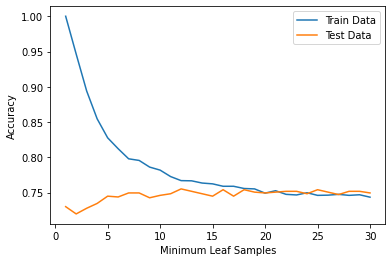

In [70]:
plt.plot(n_estimators_range, rf_train_acc_list, label='Train Data')
plt.plot(n_estimators_range, rf_test_acc_list, label='Test Data')
plt.xlabel('Minimum Leaf Samples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

مشاهده می‌شود که هرچه میزان حداقل تعداد داده‌ها در برگ‌های درخت تصمیم بیشتر باشد، کمتر شاهد overfit خواهیم بود. دلیل آن هم این است که اگر این میزان حداقلی کم باشد، درخت با ایجاد شاخه‌هایی که داده‌های کمی در آن‌ها وجود دارد، حالت‌های خاصی را پوشش می‌دهد که تنها در داده‌ی یادگیری دیده شده و همین باعث overfit می‌شود. در نتیجه با افزایش این مقدار، می‌توانیم از overfitting جلوگیری کنیم.\
در ادامه نیز معیارهای دقت مربوطه مشاهده می‌شود.

In [71]:
best_n = 20
report("random forest train",rf_train_acc[best_n], rf_train_pre[best_n], rf_train_rec[best_n])
report("random forest test",rf_test_acc[best_n], rf_test_pre[best_n], rf_test_rec[best_n])

---RANDOM FOREST TRAIN DATA REPORT:---
ACCURACY: %74
PRECISION: %74
RECALL: %74

---RANDOM FOREST TEST DATA REPORT:---
ACCURACY: %74
PRECISION: %73
RECALL: %74



In [72]:
max_depth_range = range(1,31)
rf_train_acc = {}
rf_train_acc_list = []
rf_train_pre = {}
rf_train_pre_list = []
rf_train_rec = {}
rf_train_rec_list = []
rf_test_acc = {}
rf_test_acc_list = []
rf_test_pre = {}
rf_test_pre_list = []
rf_test_rec = {}
rf_test_rec_list = []

for n in max_depth_range:
    rf = RandomForestClassifier(max_depth=n)
    rf.fit(unenc_x_train, unenc_y_train)
    rf_y_train_pred = rf.predict(unenc_x_train)
    rf_y_test_pred = rf.predict(unenc_x_test)

    rf_train_acc[n] = metrics.accuracy_score(unenc_y_train, rf_y_train_pred)
    rf_test_acc[n] = metrics.accuracy_score(unenc_y_test, rf_y_test_pred)
    rf_train_acc_list.append(rf_train_acc[n])
    rf_test_acc_list.append(rf_test_acc[n])

    rf_train_pre[n] = metrics.precision_score(unenc_y_train, rf_y_train_pred, average='weighted', zero_division=1)
    rf_test_pre[n] = metrics.precision_score(unenc_y_test, rf_y_test_pred, average='weighted', zero_division=1)
    rf_train_pre_list.append(rf_train_pre[n])
    rf_test_pre_list.append(rf_test_pre[n])

    rf_train_rec[n] = metrics.recall_score(unenc_y_train, rf_y_train_pred, average='weighted', zero_division=1)
    rf_test_rec[n] = metrics.recall_score(unenc_y_test, rf_y_test_pred, average='weighted', zero_division=1)
    rf_train_rec_list.append(rf_train_rec[n])
    rf_test_rec_list.append(rf_test_rec[n])

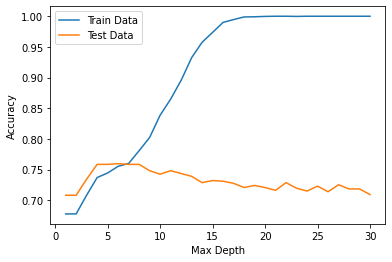

In [73]:
plt.plot(max_depth_range, rf_train_acc_list, label='Train Data')
plt.plot(max_depth_range, rf_test_acc_list, label='Test Data')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

مشاهده می‌شود که مانند استفاده از یک درخت تصمیم با عمق بالا، اگر از Random Forest با حداکثر عمق زیاد نیز استفاده کنیم، شاهد overfitting خواهیم بود.

In [74]:
best_md = 7
report("random forest train",rf_train_acc[best_md], rf_train_pre[best_md], rf_train_rec[best_md])
report("random forest test",rf_test_acc[best_md], rf_test_pre[best_md], rf_test_rec[best_md])

---RANDOM FOREST TRAIN DATA REPORT:---
ACCURACY: %76
PRECISION: %75
RECALL: %76

---RANDOM FOREST TEST DATA REPORT:---
ACCURACY: %75
PRECISION: %74
RECALL: %75



در ادامه تاثیر Bagging بر روی Overfitting را بررسی می‌کنیم. برای این کار یک مدل KNN که Overfit شده است را با همان مدل در حالت Bagging مقایسه می‌کنیم.\
با مشاهده‌ی درصدهای مربوط به دقت در هر کدام از دو حالت درمی‌یابیم که بهبود چشم‌گیری رخ داده است و فاصله‌ی بین درصدهای مربوط به داده‌ی یادگیری و داده‌ی آزمون کاهش یافته است. دلیل این امر نیز این است که در Bagging از آن‌جا که هر کدام از مدل‌ها بخشی از داده را می‌بیند و بر اساس آن تصمیم‌گیری می‌کند، در نتیجه در مجموع همه‌ی داده‌های دیده شده‌اند اما هر مدل بخشی از داده را دیده است و همین امر می‌تواند جلوی Overfitting را بگیرد. 

In [75]:
bc_knn = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=2), max_features=0.5, max_samples=0.5)
bc_knn.fit(x_train, y_train)
bagging_knn_y_test_pred = bc_knn.predict(x_test)
bagging_knn_y_train_pred = bc_knn.predict(x_train)
bagging_knn_train_acc = metrics.accuracy_score(y_train, bagging_knn_y_train_pred)
bagging_knn_test_acc = metrics.accuracy_score(y_test, bagging_knn_y_test_pred)
bagging_knn_train_pre = metrics.precision_score(y_train, bagging_knn_y_train_pred, average='weighted')
bagging_knn_test_pre = metrics.precision_score(y_test, bagging_knn_y_test_pred, average='weighted')
bagging_knn_train_rec = metrics.recall_score(y_train, bagging_knn_y_train_pred, average='weighted')
bagging_knn_test_rec = metrics.recall_score(y_test, bagging_knn_y_test_pred, average='weighted')

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(x_train, y_train)
knn_y_test_pred = knn.predict(x_test)
knn_y_train_pred = knn.predict(x_train)
knn_train_acc = metrics.accuracy_score(y_train, knn_y_train_pred)
knn_test_acc = metrics.accuracy_score(y_test, knn_y_test_pred)
knn_train_pre = metrics.precision_score(y_train, knn_y_train_pred, average='weighted')
knn_test_pre = metrics.precision_score(y_test, knn_y_test_pred, average='weighted')
knn_train_rec = metrics.recall_score(y_train, knn_y_train_pred, average='weighted')
knn_test_rec = metrics.recall_score(y_test, knn_y_test_pred, average='weighted')

report("overfit knn train",knn_train_acc, knn_train_pre, knn_train_rec)
report("overfit knn test",knn_test_acc, knn_test_pre, knn_test_rec)
report("bagging knn train",bagging_knn_train_acc, bagging_knn_train_pre, bagging_knn_train_rec)
report("bagging knn test",bagging_knn_test_acc, bagging_knn_test_pre, bagging_knn_test_rec)

---OVERFIT KNN TRAIN DATA REPORT:---
ACCURACY: %81
PRECISION: %88
RECALL: %81

---OVERFIT KNN TEST DATA REPORT:---
ACCURACY: %55
PRECISION: %64
RECALL: %55

---BAGGING KNN TRAIN DATA REPORT:---
ACCURACY: %84
PRECISION: %84
RECALL: %84

---BAGGING KNN TEST DATA REPORT:---
ACCURACY: %71
PRECISION: %70
RECALL: %71



عمل Bootstrapping به این اتلاق می‌شود که زیرمجموعه‌هایی از داده را با جای‌گذاری انتخاب کرده و به تعداد مختلفی از یک مدل برای یادگیری بدهیم. این کار باعث کاهش واریانس می‌شود، چون نهایتا با میانگین نظرات همه‌ی این مدل‌ها روی پاسخ تصمیم‌گیری می‌شود. اما این کار باعث افزایش بایاس می‌شود؛ چرا که حالا هر مدل تعداد داده‌های کم‌تری مشاهده می‌کند و این باعث می‌شود که هر مدل ساده‌نگرتر باشد.

نهایتاً با سه مدل فاز اول، مدل جمعی Hard Voting را پیاده‌سازی می‌کنیم که در انتها درصدهای مربوط به معیارهای دقت برای آن آمده است.

In [76]:
from sklearn.ensemble import VotingClassifier

knn = KNeighborsClassifier(n_neighbors=best_k)
lr = LogisticRegression(max_iter=1000)
dt = DecisionTreeClassifier(max_depth=best_d)

vclf = VotingClassifier(estimators=[('knn', knn), ('dt', dt), ('lr', lr)])
vclf.fit(unenc_x_train, unenc_y_train)
vclf_y_test_pred = vclf.predict(unenc_x_test)
vclf_y_train_pred = vclf.predict(unenc_x_train)
vclf_train_acc = metrics.accuracy_score(unenc_y_train, vclf_y_train_pred)
vclf_test_acc = metrics.accuracy_score(unenc_y_test, vclf_y_test_pred)
vclf_train_pre = metrics.precision_score(unenc_y_train, vclf_y_train_pred, average='weighted')
vclf_test_pre = metrics.precision_score(unenc_y_test, vclf_y_test_pred, average='weighted')
vclf_train_rec = metrics.recall_score(unenc_y_train, vclf_y_train_pred, average='weighted')
vclf_test_rec = metrics.recall_score(unenc_y_test, vclf_y_test_pred, average='weighted')

report("voting classifier train",vclf_train_acc, vclf_train_pre, vclf_train_rec)
report("voting classifier test",vclf_test_acc, vclf_test_pre, vclf_test_rec)

---VOTING CLASSIFIER TRAIN DATA REPORT:---
ACCURACY: %73
PRECISION: %73
RECALL: %73

---VOTING CLASSIFIER TEST DATA REPORT:---
ACCURACY: %74
PRECISION: %71
RECALL: %74



در ادامه علت عدم بهبود درصدهای این نوع یادگیری گروهی را بررسی می‌کنیم.

In [87]:
dtc = DecisionTreeClassifier(max_depth=best_d)
dtc.fit(unenc_x_train, unenc_y_train)
dt_y_test_pred = dtc.predict(unenc_x_test)

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(scaler.fit_transform(x_train), y_train)
knn_y_test_pred = knn.predict(scaler.fit_transform(x_test))

lr = LogisticRegression(max_iter=1000)
lr.fit(x_train, y_train)
lr_y_test_pred = lr.predict(x_test)

metrics.accuracy_score(dt_y_test_pred, knn_y_test_pred)

0.8741418764302059

In [88]:
metrics.accuracy_score(lr_y_test_pred, knn_y_test_pred)

0.8432494279176201

In [89]:
metrics.accuracy_score(lr_y_test_pred, dt_y_test_pred)

0.8089244851258581

با مقایسه‌ی دوبه‌دوی درصد شباهت پاسخ‌های مدل‌های فاز اول، درمی‌یابیم که این مدل‌ها شباهت بالایی به هم دیگر دارند. در نتیجه در اکثر موارد، رأی آن‌ها یکسان است و در واقع رای‌گیری هیچ اثری ندارد. لذا نمی‌توانیم با استفاده از روشی مثل Hard Voting به پیشرفت خاصی در معیارهای دقت دست پیدا کنیم. این روش در جایی می‌تواند درصدهای معیارهای دقت را به چالش بکشد که تفاوت زیادی بین آن‌ها وجود داشته باشد و هم‌چنین رای‌گیری هم میان تعداد مدل زیادی انجام بگیرد تا بتوانیم حدودا از پاسخ‌های تصادفی جلوگیری کنیم. پس به دلایل گفته‌شده شاهد بهبود چشم‌گیر و خاصی در درصدهای مربوط به یادگیری گروهی نیستیم.